In [ ]:
No pip install numpy pandas matplotlib scikit-learn tensorflow


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Load the dataset
file_path = '/content/crime.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())


            STATE/UT   CRIME HEAD  2001  2002  2003  2004  2005  2006  2007  \
0     ANDHRA PRADESH  INFANTICIDE     1     1     3     0     0     0     1   
1  ARUNACHAL PRADESH  INFANTICIDE     0     0     0     0     0     0     0   
2              ASSAM  INFANTICIDE     0     5     0     0     1     0     0   
3              BIHAR  INFANTICIDE     0     0     0     0     2     0     2   
4       CHHATTISGARH  INFANTICIDE     7    29     5    12     0    15    11   

   2008  2009  2010  2011  2012  
0     0     5     6     1     6  
1     0     0     0     0     0  
2     0     0     0     0     0  
3     2     0     2     5     2  
4     6     2     0    10     5  


In [ ]:
print(data.shape)

(494, 14)


In [ ]:
# Check the raw data before transforming
print(data.head())
print(data.info())


            STATE/UT   CRIME HEAD  2001  2002  2003  2004  2005  2006  2007  \
0     ANDHRA PRADESH  INFANTICIDE     1     1     3     0     0     0     1   
1  ARUNACHAL PRADESH  INFANTICIDE     0     0     0     0     0     0     0   
2              ASSAM  INFANTICIDE     0     5     0     0     1     0     0   
3              BIHAR  INFANTICIDE     0     0     0     0     2     0     2   
4       CHHATTISGARH  INFANTICIDE     7    29     5    12     0    15    11   

   2008  2009  2010  2011  2012  
0     0     5     6     1     6  
1     0     0     0     0     0  
2     0     0     0     0     0  
3     2     0     2     5     2  
4     6     2     0    10     5  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   STATE/UT    494 non-null    object
 1   CRIME HEAD  494 non-null    object
 2   2001        494 non-null    int64 
 3   2002       

In [ ]:
data.head()

,STATE/UT,CRIME HEAD,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
0,ANDHRA PRADESH,INFANTICIDE,1,1,3,0,0,0,1,0,5,6,1,6
1,ARUNACHAL PRADESH,INFANTICIDE,0,0,0,0,0,0,0,0,0,0,0,0
2,ASSAM,INFANTICIDE,0,5,0,0,1,0,0,0,0,0,0,0
3,BIHAR,INFANTICIDE,0,0,0,0,2,0,2,2,0,2,5,2
4,CHHATTISGARH,INFANTICIDE,7,29,5,12,0,15,11,6,2,0,10,5


In [ ]:
df_long = data.melt(id_vars=['STATE/UT', 'CRIME HEAD'], var_name='year', value_name='cases')
# 'data' is the variable you defined when reading the csv file

In [ ]:
# Pivot data
df_pivot = df_long.pivot_table(index=['STATE/UT', 'CRIME HEAD'], columns='year', values='cases')

# Fill missing values if any
df_pivot.fillna(0, inplace=True)


In [ ]:
print(df_pivot.head())
print(df_pivot.shape)

year                                            2001  2002  2003  2004  2005  \
STATE/UT      CRIME HEAD                                                       
A & N ISLANDS  TOTAL CRIMES AGAINST CHILDREN     0.0   0.0   4.0  20.0  17.0   
              ABETMENT OF SUICIDE                0.0   0.0   0.0   0.0   0.0   
              BUYING OF GIRLS FOR PROSTITUTION   0.0   0.0   0.0   0.0   0.0   
              EXPOSURE AND ABANDONMENT           0.0   0.0   0.0   0.0   0.0   
              FOETICIDE                          0.0   0.0   0.0   0.0   0.0   

year                                            2006  2007  2008  2009  2010  \
STATE/UT      CRIME HEAD                                                       
A & N ISLANDS  TOTAL CRIMES AGAINST CHILDREN    10.0   9.0  52.0  63.0  61.0   
              ABETMENT OF SUICIDE                0.0   0.0   0.0   0.0   0.0   
              BUYING OF GIRLS FOR PROSTITUTION   0.0   0.0   0.0   0.0   0.0   
              EXPOSURE AND ABANDONMENT 

In [ ]:
df_reset = df_pivot.reset_index()

In [ ]:
df_long = df_reset.melt(id_vars=['STATE/UT', 'CRIME HEAD'], var_name='year', value_name='cases')
df_long['year'] = df_long['year'].astype(int)

In [ ]:
def create_sequences(df, sequence_length):
    X, y, y_true = [], [], []

    for state in df['STATE/UT'].unique():
        for crime in df['CRIME HEAD'].unique():
            subset = df[(df['STATE/UT'] == state) & (df['CRIME HEAD'] == crime)]

            # Pivot to get years as rows and arrests as values
            values = subset.pivot(index='year', columns='CRIME HEAD', values='cases').values

            # Create sequences
            for i in range(len(values) - sequence_length):
                X.append(values[i:i+sequence_length])
                y.append(values[i+sequence_length])
                y_true.append(values[i+sequence_length])  # Save actual values

    return np.array(X), np.array(y), np.array(y_true)

# Create sequences with a specified length
sequence_length = 5
X, y, y_true = create_sequences(df_long, sequence_length)


In [ ]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_reshaped = X.reshape(-1, X.shape[2])
X_scaled = scaler_X.fit_transform(X_reshaped).reshape(X.shape)

# Initialize and fit scaler for y
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).reshape(y.shape)

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
print(model.summary())

# Train the model
history = model.fit(X_scaled, y_scaled, epochs=10, batch_size=32, validation_split=0.2)

# Predict with the model
y_pred_scaled = model.predict(X_scaled)

# Output actual and predicted values
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(y_scaled.shape) # Use scaler_y to inverse transform
y_true_original = scaler_y.inverse_transform(y_true.reshape(-1, 1)).reshape(y_true.shape) # Use scaler_y to inverse transform

comparison_df = pd.DataFrame({
    'Actual': y_true_original.flatten(),
    'Predicted': y_pred.flatten()
})

print(comparison_df.head())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 3.9023e-05 - val_loss: 0.0026
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.3380e-06 - val_loss: 9.5076e-04
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.7587e-06 - val_loss: 9.1450e-04
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.3931e-06 - val_loss: 0.0011
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.6308e-06 - val_loss: 9.9395e-04
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.4657e-06 - val_loss: 8.6702e-04
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.4274e-06 - val_loss: 0.0012
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.3305e-06 - val_loss: 0.0010
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8932e-06 - val_loss: 0.0010
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.4487e-06 - val_loss: 0.0011
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
      Actual  Predicted
0   421170.0 -33.885132
1   3790

In [ ]:
def predict_future(model, last_sequence, scaler_y, num_steps=3):
    predictions = []
    sequence = last_sequence

    for _ in range(num_steps):
        y_pred_scaled = model.predict(sequence)
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(1, -1)
        predictions.append(y_pred.flatten())

        # Update sequence with the new prediction
        sequence = np.roll(sequence, shift=-1, axis=1)
        sequence[0, -1, 0] = y_pred.flatten()[0]

    return predictions

# Predict future values
last_sequence = X[-1].reshape((1, sequence_length, X.shape[2]))
future_predictions = predict_future(model, last_sequence, scaler_y, num_steps=3)

# Flatten the list of arrays and handle potential issues
future_predictions_flat = np.concatenate(future_predictions) if future_predictions else []

# Debug print statements
print(f"Crime Heads: {crime_heads}")
print(f"Number of Crime Heads: {num_crime_heads}")
print(f"Number of Years: {num_years}")
print(f"Future Predictions Length: {len(future_predictions_flat)}")

# Check if lengths match
expected_length = num_crime_heads * num_years
print(f"Expected Length: {expected_length}")

if len(future_predictions_flat) == expected_length:
    predictions_df = pd.DataFrame({
        'Crime Head': np.tile(crime_heads, num_years),
        'Year': np.repeat(range(2013, 2013 + num_years), num_crime_heads),
        'Predicted Arrests': future_predictions_flat
    })
else:
    #print("Mismatch in lengths. Adjusting data.")
    # Adjust predictions to fit the expected length
    adjusted_predictions = np.resize(future_predictions_flat, expected_length)

    predictions_df = pd.DataFrame({
        'Crime Head': np.tile(crime_heads, num_years),
        'Year': np.repeat(range(2013, 2013 + num_years), num_crime_heads),
        'Predicted Arrests': adjusted_predictions
    })

print(predictions_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


NameError: name 'crime_heads' is not defined

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
mse = mean_squared_error(y_true_original, y_pred)
mae = mean_absolute_error(y_true_original, y_pred)
r2 = r2_score(y_true_original, y_pred)

# Output metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")


Mean Squared Error (MSE): 8166570343933413.0
Mean Absolute Error (MAE): 14621615.720267277
R-squared (R2): -0.02684681625181229


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# Assuming df_pivot contains the crime data with states and crime types
# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(df_pivot)

# Apply K-Means clustering
num_clusters = 5  # You can adjust this number
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(data_normalized)

# Add cluster labels to the original DataFrame
df_pivot['Cluster'] = clusters

print(df_pivot.head())


year                                            2001  2002  2003  2004  2005  \
STATE/UT      CRIME HEAD                                                       
A & N ISLANDS  TOTAL CRIMES AGAINST CHILDREN     0.0   0.0   4.0  20.0  17.0   
              ABETMENT OF SUICIDE                0.0   0.0   0.0   0.0   0.0   
              BUYING OF GIRLS FOR PROSTITUTION   0.0   0.0   0.0   0.0   0.0   
              EXPOSURE AND ABANDONMENT           0.0   0.0   0.0   0.0   0.0   
              FOETICIDE                          0.0   0.0   0.0   0.0   0.0   

year                                            2006  2007  2008  2009  2010  \
STATE/UT      CRIME HEAD                                                       
A & N ISLANDS  TOTAL CRIMES AGAINST CHILDREN    10.0   9.0  52.0  63.0  61.0   
              ABETMENT OF SUICIDE                0.0   0.0   0.0   0.0   0.0   
              BUYING OF GIRLS FOR PROSTITUTION   0.0   0.0   0.0   0.0   0.0   
              EXPOSURE AND ABANDONMENT 

In [ ]:
import pandas as pd

# List of state names (example)
states = [
    'State1', 'State2', 'State3', 'State4', 'State5', 'State6',
    'State7', 'State8', 'State9', 'State10', 'State11', 'State12', 'State13'
]

# Example cluster data (make sure it's the same length as the states list)
# If you have fewer clusters than states, repeat the cluster list to match
clusters = [0, 1, 2]  # Example clusters
num_states = len(states)
num_clusters = len(clusters)

# Repeat clusters to match the length of states
repeated_clusters = clusters * (num_states // num_clusters) + clusters[:num_states % num_clusters]

# Check lengths
print(f"Length of states list: {len(states)}")
print(f"Length of repeated clusters list: {len(repeated_clusters)}")

# Create DataFrame
state_cluster_data = pd.DataFrame({
    'STATE/UT': states,
    'Cluster': repeated_clusters
})

print(state_cluster_data)


Length of states list: 13
Length of repeated clusters list: 13
   STATE/UT  Cluster
0    State1        0
1    State2        1
2    State3        2
3    State4        0
4    State5        1
5    State6        2
6    State7        0
7    State8        1
8    State9        2
9   State10        0
10  State11        1
11  State12        2
12  State13        0


In [ ]:
# Correct state names corresponding to the clusters
actual_state_names = [
    'Andaman and Nicobar', 'Andhra Pradesh', 'Arunachal Pradesh', 'Assam',
    'Bihar', 'Chandigarh', 'Chhattisgarh', 'Dadra and Nagar Haveli',
    'Daman and Diu', 'Delhi', 'Goa', 'Gujarat', 'Haryana'
]

# Update state names in state_cluster_data
state_cluster_data['STATE/UT'] = actual_state_names

# Check the updated DataFrame
print(state_cluster_data)


                  STATE/UT  Cluster
0      Andaman and Nicobar        0
1           Andhra Pradesh        1
2        Arunachal Pradesh        2
3                    Assam        0
4                    Bihar        1
5               Chandigarh        2
6             Chhattisgarh        0
7   Dadra and Nagar Haveli        1
8            Daman and Diu        2
9                    Delhi        0
10                     Goa        1
11                 Gujarat        2
12                 Haryana        0


In [ ]:
# Define the list of crime heads
crime_head_values = [
    'Total Crimes Against Children', 'Abetment of Suicide', 'Buying of Girls for Prostitution',
    'Exposure and Abandonment', 'Foeticide', 'Infanticide', 'Kidnapping and Abduction of Children',
    'Murder of Children', 'Other Crimes Against Children', 'Procurement of Minor Girls',
    'Prohibition of Child Marriage Act', 'Rape of Children', 'Selling of Girls for Prostitution'
]

# Ensure this list matches the length and order of your states


In [ ]:
import pandas as pd

# Define lists
states = ['State1', 'State2', 'State3', 'State4', 'State5', 'State6', 'State7', 'State8',
          'State9', 'State10', 'State11', 'State12', 'State13']  # Length 13

clusters = [0, 1, 2]  # Length 3
crime_head_values = [
    'Total Crimes Against Children', 'Abetment of Suicide', 'Buying of Girls for Prostitution',
    'Exposure and Abandonment', 'Foeticide', 'Infanticide', 'Kidnapping and Abduction of Children',
    'Murder of Children', 'Other Crimes Against Children', 'Procurement of Minor Girls',
    'Prohibition of Child Marriage Act', 'Rape of Children', 'Selling of Girls for Prostitution'
]  # Length 13

# Adjust clusters to match the length of states
num_states = len(states)
num_clusters = len(clusters)

# Repeat clusters to match length
repeated_clusters = clusters * (num_states // num_clusters) + clusters[:num_states % num_clusters]

# Verify lengths
print(f"Length of states: {len(states)}")
print(f"Length of repeated_clusters: {len(repeated_clusters)}")
print(f"Length of crime_head_values: {len(crime_head_values)}")

# Create DataFrame
state_cluster_data = pd.DataFrame({
    'STATE/UT': states,
    'Cluster': repeated_clusters,
    'Crime Head': crime_head_values
})

print(state_cluster_data)


Length of states: 13
Length of repeated_clusters: 13
Length of crime_head_values: 13
   STATE/UT  Cluster                            Crime Head
0    State1        0         Total Crimes Against Children
1    State2        1                   Abetment of Suicide
2    State3        2      Buying of Girls for Prostitution
3    State4        0              Exposure and Abandonment
4    State5        1                             Foeticide
5    State6        2                           Infanticide
6    State7        0  Kidnapping and Abduction of Children
7    State8        1                    Murder of Children
8    State9        2         Other Crimes Against Children
9   State10        0            Procurement of Minor Girls
10  State11        1     Prohibition of Child Marriage Act
11  State12        2                      Rape of Children
12  State13        0     Selling of Girls for Prostitution


In [ ]:
clusters = clusters * (len(states) // len(clusters)) + clusters[:len(states) % len(clusters)]


In [ ]:
# Example mapping from your state names to the ones used in india_map
name_mapping = {
    'State1': 'Andaman and Nicobar',
    'State2': 'Andhra Pradesh',
    'State3': 'Arunachal Pradesh',
    'State4': 'Assam',
    'State5': 'Bihar',
    'State6': 'Chandigarh',
    'State7': 'Chhattisgarh',
    'State8': 'Dadra and Nagar Haveli',
    'State9': 'Daman and Diu',
    'State10': 'Delhi',
    'State11': 'Goa',
    'State12': 'Gujarat',
    'State13': 'Haryana'
    # Add mappings for all states as needed
}


In [ ]:
state_cluster_data['STATE/UT'] = state_cluster_data['STATE/UT'].map(name_mapping)


In [ ]:
print(state_cluster_data['STATE/UT'].isna().sum())


0


In [ ]:

import geopandas as gpd

# Load the map data from a file
india_map = gpd.read_file('/content/india_state_geo.json')

# Now you can proceed with the merge operation
df_map = india_map.merge(state_cluster_data, left_on='NAME_1', right_on='STATE/UT', how='left')

# Check the result of the merge
print(df_map.head())
print(df_map.info())

   ID_0  ISO NAME_0  ID_1               NAME_1 NL_NAME_1  \
0   105  IND  India     1  Andaman and Nicobar      None   
1   105  IND  India     2       Andhra Pradesh      None   
2   105  IND  India     3    Arunachal Pradesh      None   
3   105  IND  India     4                Assam      None   
4   105  IND  India     5                Bihar      None   

                                           VARNAME_1          TYPE_1  \
0  Andaman & Nicobar Islands|Andaman et Nicobar|I...  Union Territor   
1                                               None           State   
2  Agence de la Frontire du Nord-Est(French-obsol...           State   
3                                               None           State   
4                                               None           State   

         ENGTYPE_1                                           geometry  \
0  Union Territory  MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8...   
1            State  MULTIPOLYGON (((80.27458 13.45958, 80.27

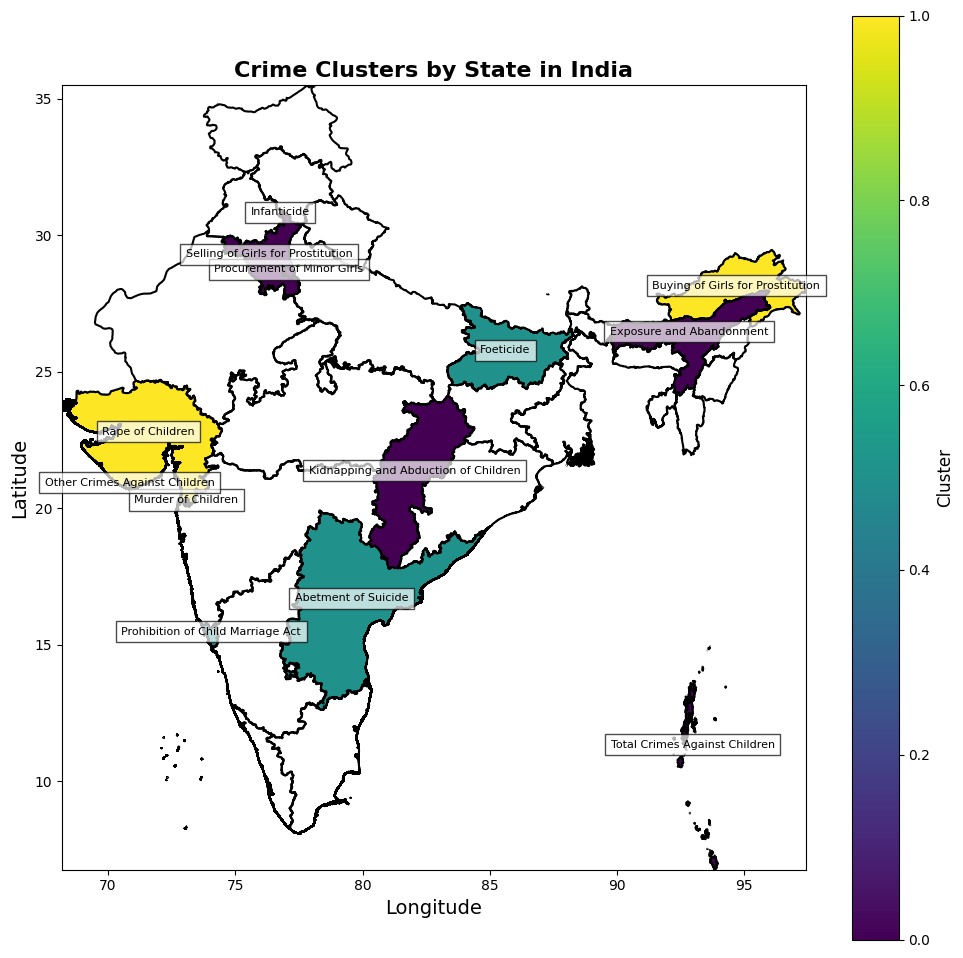

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Plot the entire outline of India
india_map.boundary.plot(ax=ax, linewidth=1.5, color='black')

# Overlay the states with clusters
plot = df_map.plot(column='Cluster', ax=ax, cmap='viridis', edgecolor='k', legend=False)

# Setting the x and y axis limits to ensure the entire map is visible
ax.set_xlim(india_map.total_bounds[0], india_map.total_bounds[2])
ax.set_ylim(india_map.total_bounds[1], india_map.total_bounds[3])

# Adding axis labels
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Adding a title
ax.set_title('Crime Clusters by State in India', fontsize=16, fontweight='bold')

# Customizing the legend manually
cbar = plot.get_figure().colorbar(plot.collections[0], ax=ax)
cbar.set_label('Cluster')
cbar.ax.set_ylabel('Cluster', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Add text annotations for crime heads
for idx, row in df_map.dropna(subset=['Cluster']).iterrows():
    if row.geometry.is_valid:
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y,
                f"{row['Crime Head']}",
                fontsize=8, ha='center', color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

plt.show()


In [ ]:
pip install numpy pandas matplotlib scikit-learn geopandas folium
